In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from utils import misc
import datetime as dt
from trade_obj import *

from simple_backtester import backTester
df = pd.read_csv('datasets/daily_price_series/LABU.csv')
df = misc.clean_df(df)
df = df.set_index('date')



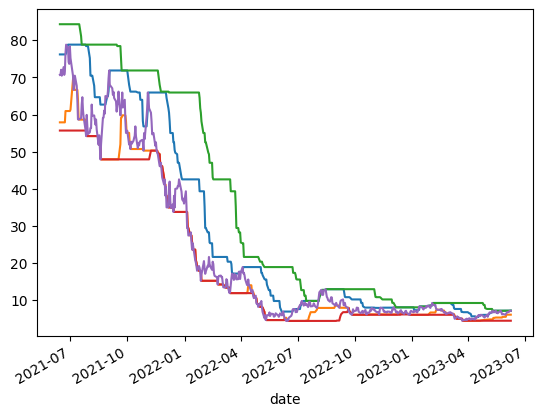

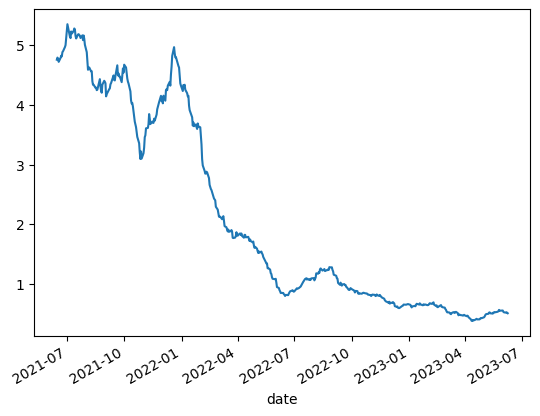

In [141]:
df['20_up_bound'] = df['close'].shift(1).rolling(20).max()
df['20_low_bound'] = df['close'].shift(1).rolling(20).min()
df['10_up_bound'] = df['close'].shift(1).rolling(10).max()
df['10_low_bound'] = df['close'].shift(1).rolling(10).min()
df['55_up_bound'] = df['close'].shift(1).rolling(55).max()
df['55_low_bound'] = df['close'].shift(1).rolling(55).min()



df = df.dropna()


df['High-Low'] = df['high'] - df['low']
df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
df['ATR'] = df['TR'].rolling(20).mean()


df1 = df[-500:].copy()
df1['20_up_bound'].plot()
df1['20_low_bound'].plot()
df1['55_up_bound'].plot()
df1['55_low_bound'].plot()
df1['close'].plot()
plt.show()

df1['ATR'].plot()
plt.show()

In [142]:
bt = backTester()
df = df.dropna()
# df = df[-1000:]
bt.set_asset(df)

upbound20 = df['20_up_bound'].to_numpy()
lowbound20 = df['20_low_bound'].to_numpy()
upbound10 = df['10_up_bound'].to_numpy()
lowbound10 = df['10_low_bound'].to_numpy()
upbound55 = df['55_up_bound'].to_numpy()
lowbound55 = df['55_low_bound'].to_numpy()
atr = df['ATR'].to_numpy()

stop_loss_arr = []
stop_loss = np.nan

tl = tradeList()
last_trade_win = False
open_trade = None
open_trade55 = None


for i in range(len(bt.df)):
    
    order_quantity = 0
    order_price = 0
    n = atr[i]
    # risk_unit = int(bt.portfolio_value * 0.02 / (3 * n))
    risk_unit = bt.cash // bt.high[i]
    

    # no open trades
    if open_trade == None:
        # breakout from 20 day high
        if bt.low[i] < lowbound20[i]:
            # print(f'--- index {i}, date: {bt.date[i]} ---')
            # print(f'high: {bt.high[i]} > long breakout: {upbound20[i]}')
            short_entry_price = lowbound20[i]
            # calculate stop_loss
            stop_loss = short_entry_price + 2 * n
            
            if not last_trade_win:
                
                # order price at breakout
                order_price = short_entry_price
                # order 1 unit
                order_quantity = -risk_unit
                
                # open trade on record
                open_trade = trade(bt.date[i], order_price, order_quantity, type='long20')
                # print(f'entry price: {order_price}, quantity: {order_quantity}')

            else:
                short_entry_price = lowbound20[i]
                # print('last trade was profitable: fake trade')
                open_trade = fakeTrade(-1)

            

    # open trades present 
    else:
        # if open trades are long
        if open_trade.quantity < 0:
            pass
            # calculate trailing stop_loss
            stop_loss = min(stop_loss, bt.low[i] + 3.0 * n)
            # print(f'stop_loss {stop_loss}')
            # print(f'lowbound10 {lowbound10[i]}')
            # combine low bound 10 and trailing stop loss
            stop_loss = min(stop_loss, upbound10[i])
            

            # exit trade if stop loss is triggered
            if bt.high[i] > stop_loss:
                if open_trade.type == 'fake':
                    # close fake trade
                    last_trade_win = True if stop_loss < short_entry_price else False
                else:
                    # print(f'--- index {i}, date: {bt.date[i]} ---')
                    # print(f'low: {bt.low[i]} < stop_loss: {stop_loss}')
                    # exit price at stoploss
                    order_price = stop_loss
                    order_quantity = -open_trade.quantity
                        
                    open_trade.close(bt.date[i], order_price)
                    tl.append(open_trade)
                    if order_price > short_entry_price:
                        last_trade_profit = -1
                    else:
                        last_trade_profit = 1
                    entry_exit = order_price
                
                open_trade = None
                stop_loss = np.nan
    
    


        
    stop_loss_arr.append(stop_loss)

    bt.take_action(order_quantity=order_quantity, order_price=order_price)
            

df['stop_loss'] = stop_loss_arr


df['entry_price'] = np.nan
df['exit_price'] = np.nan
df['entry_price'] = np.nan
df['exit_price'] = np.nan
for t in tl.list:

    for i in range(len(t.entry_date)):
        df.loc[df.index == t.entry_date[i], 'entry_price'] = t.entry_price[i]
        
    df.loc[df.index == t.exit_date, 'exit_price'] = t.exit_price



end


In [143]:
print(len(bt.date))

1949


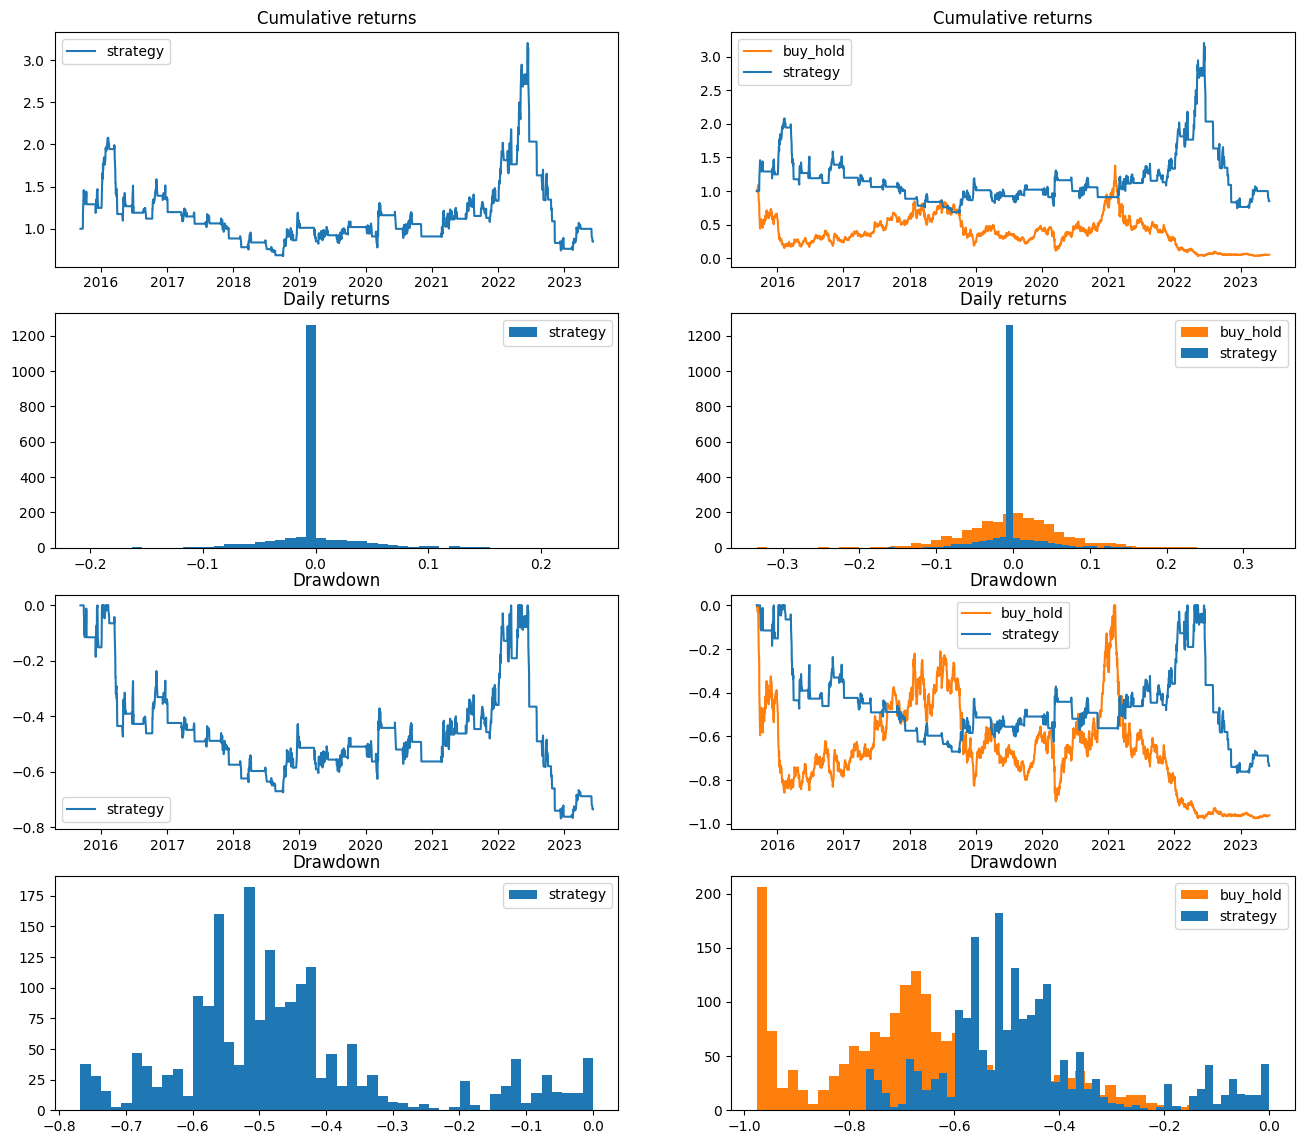

In [144]:
bt.analyse()
bt.plot_graphs()

<Axes: xlabel='date'>

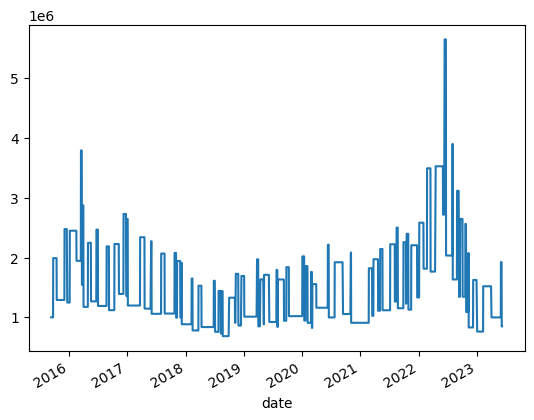

In [145]:
bt.records['cash'].plot()

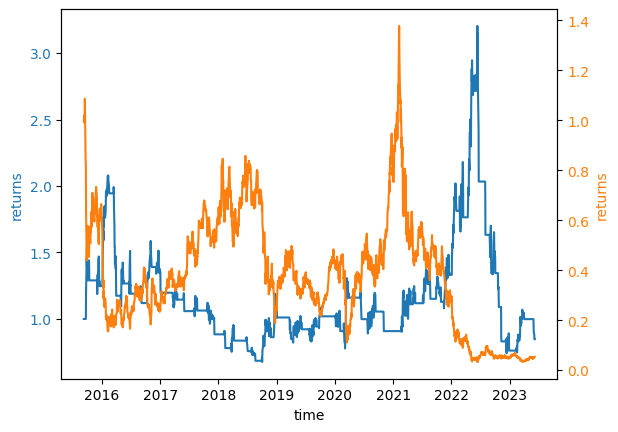

In [146]:

fig, ax1 = plt.subplots()

color = 'C0'
ax1.set_xlabel('time')
ax1.set_ylabel('returns', color=color)
ax1.plot(bt.date, bt.records['cum_returns'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'C1'
ax2 = ax1.twinx()
ax2.set_ylabel('returns', color=color)
ax2.plot(bt.date, bt.records['buy_hold_cum_returns'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [147]:
print(f'Annualised return:          {bt.annual_return}')
print(f'buy_hold annual return:     {bt.buy_hold_annual_return}')
print(f'Annualised vol:             {bt.annual_vol}')
print(f'buy_hold annual vol:        {bt.buy_hold_annual_vol}')
print(f'Sharpe ratio:               {bt.sharpe}')
print(f'buy_hold Sharpe ratio:      {bt.buy_hold_sharpe}')

Annualised return:          -0.021126660531053054
buy_hold annual return:     -0.31531973741630226
Annualised vol:             0.5174127582850268
buy_hold annual vol:        1.0390838808070102
Sharpe ratio:               -0.04083134826647438
buy_hold Sharpe ratio:      -0.303459367660874


In [148]:
tl.analyse(bt.df)
tl.stats

{'num_wins': 25,
 'num_loss': 33,
 'win_rate': 0.43103448275862066,
 'profit_total': -152335.4898495681,
 'profit_mean': -2626.4739629235883,
 'returns_mean': 0.010800614406883284,
 'returns_std': 0.1930529723373461,
 'time_in_trade_mean': 17.74137931034483,
 'time_in_trade_std': 12.669289218113066,
 'capital_at_risk_mean': 1083019.1838405132,
 'win_returns_mean': 0.18007075002691642,
 'win_returns_std': 0.17121083001332085,
 'win_profit_mean': 189728.9971278267,
 'win_time_in_trade_mean': 28.0,
 'win_time_in_trade_std': 11.390785749894517,
 'loss_returns_mean': -0.11743433682041456,
 'loss_returns_std': 0.07112377806998525,
 'loss_profit_mean': -148350.31569834045,
 'loss_time_in_trade_mean': 9.969696969696969,
 'loss_time_in_trade_std': 6.640241187660508}

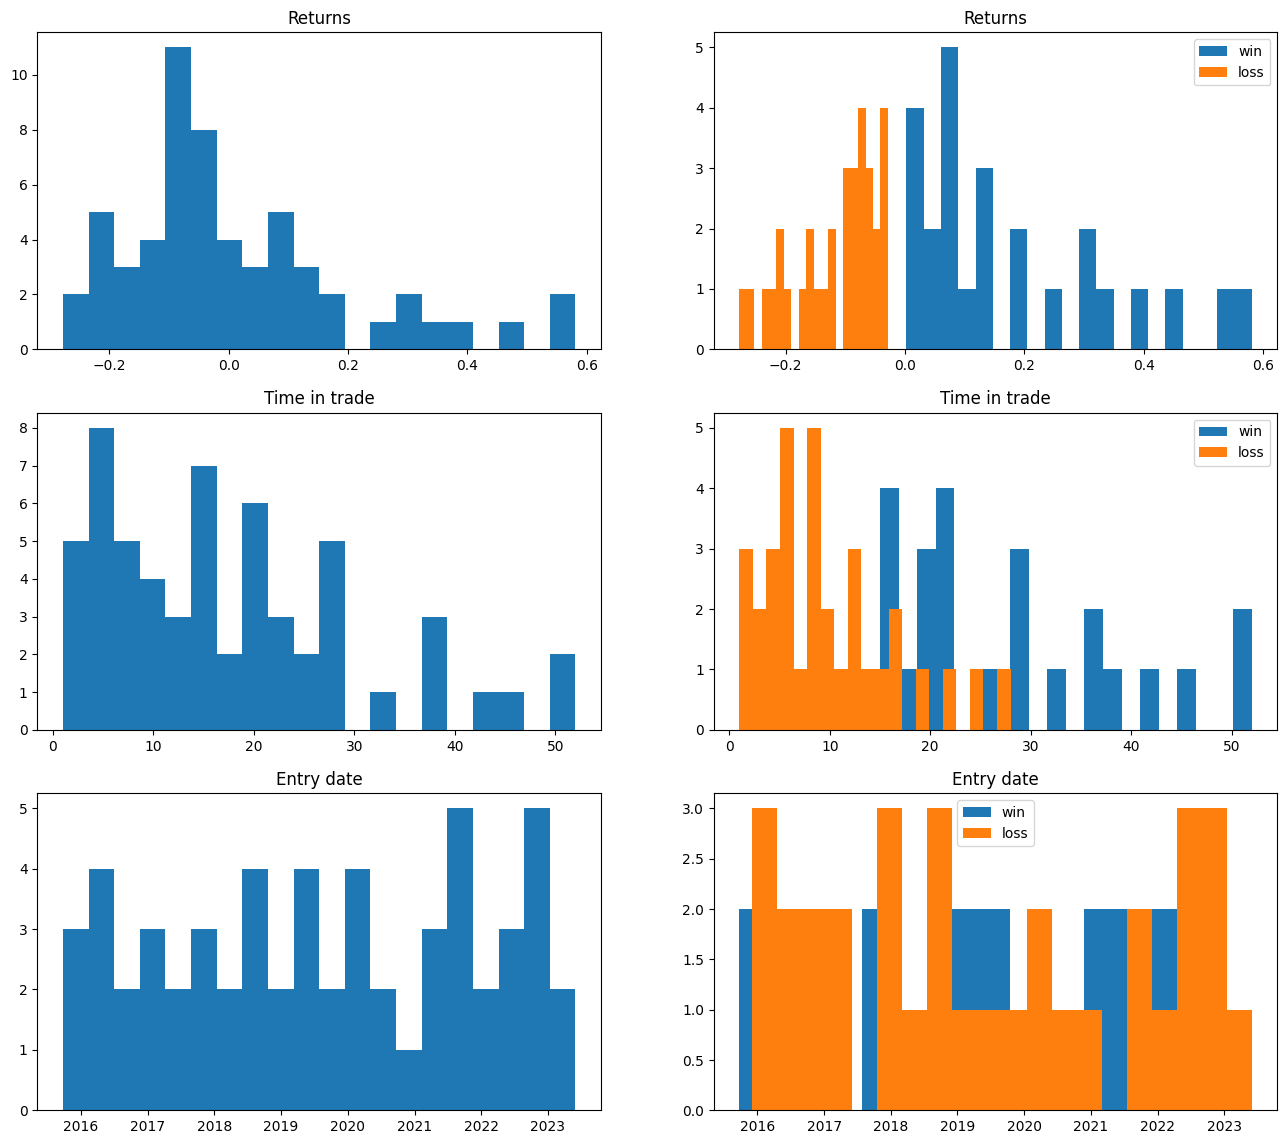

In [149]:
tl.plot_graphs()

trade 0
entry: [109.68000030517578]
cost_basis: 109.68000030517578
exit: 77.5199966430664
returns: 0.29321666277011993
17


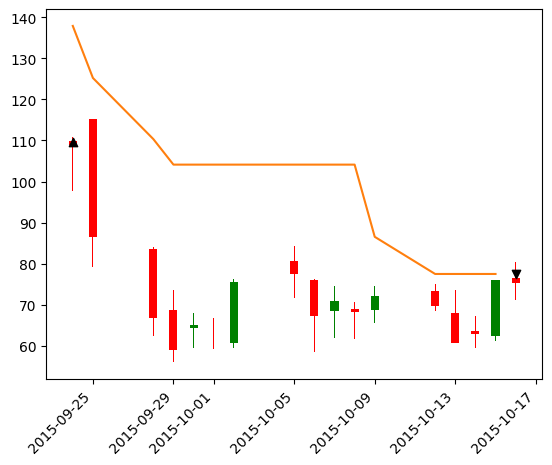

trade 1
entry: [79.76000213623047]
cost_basis: 79.76000213623047
exit: 82.63999938964844
returns: -0.036108289572245995
12


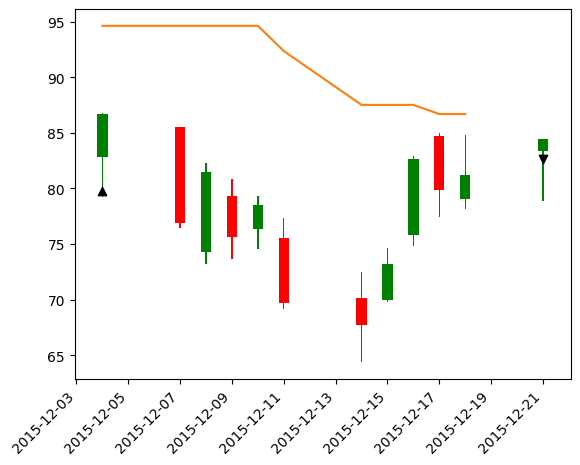

trade 2
entry: [67.68000030517578]
cost_basis: 67.68000030517578
exit: 28.36000061035156
returns: 0.5809692600107339
29


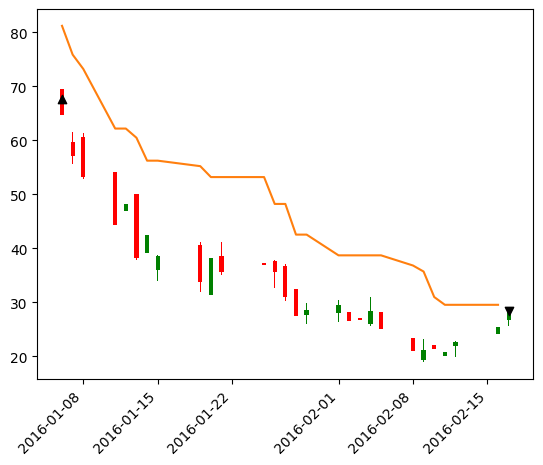

trade 3
entry: [23.520000457763672]
cost_basis: 23.520000457763672
exit: 28.63999938964844
returns: -0.21768702518008323
5


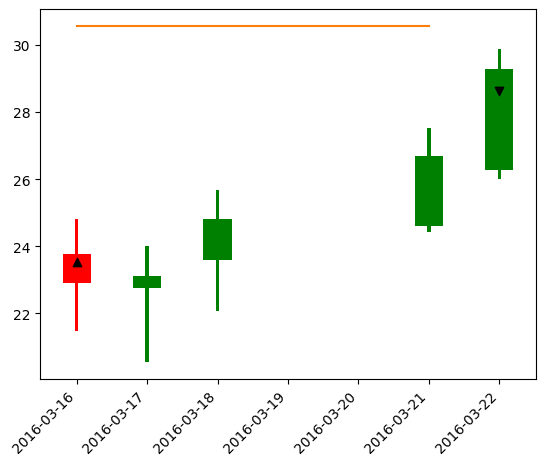

trade 4
entry: [22.920000076293945]
cost_basis: 22.920000076293945
exit: 29.280000686645508
returns: -0.27748693670074126
6


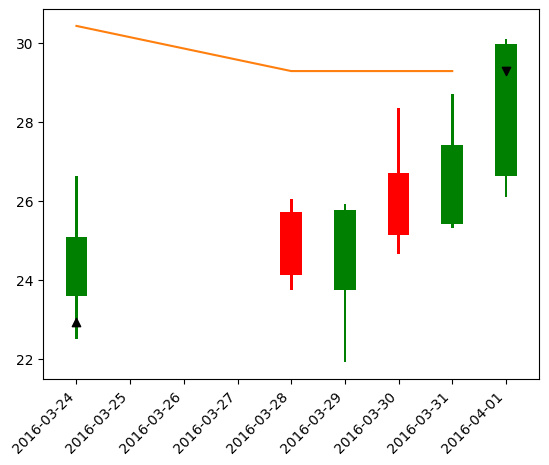

trade 5
entry: [29.96999931335449]
cost_basis: 29.969999313354485
exit: 27.38999938964844
returns: 0.08608608551273501
14


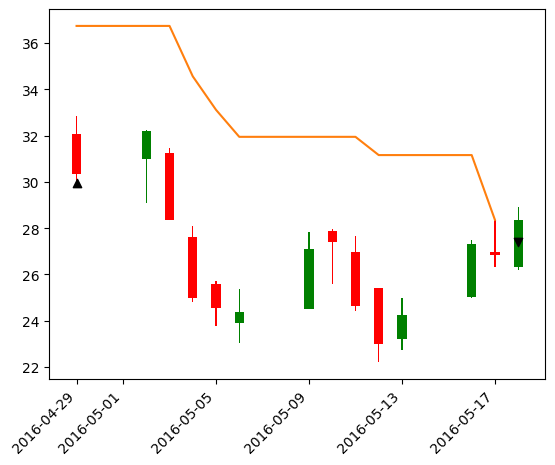

trade 6
entry: [27.950000762939453]
cost_basis: 27.950000762939453
exit: 29.739999771118164
returns: -0.06404289657666756
9


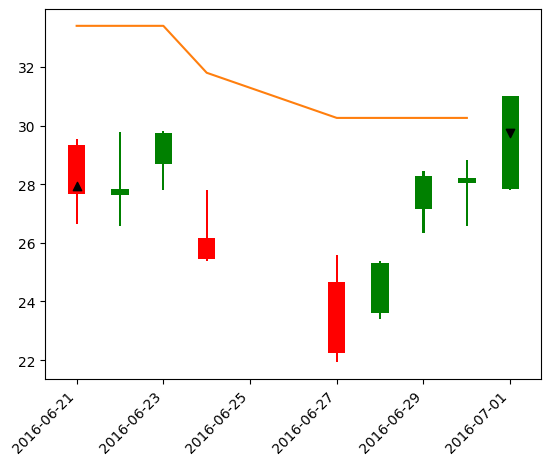

trade 7
entry: [39.459999084472656]
cost_basis: 39.459999084472656
exit: 42.25
returns: -0.07070453573895792
11


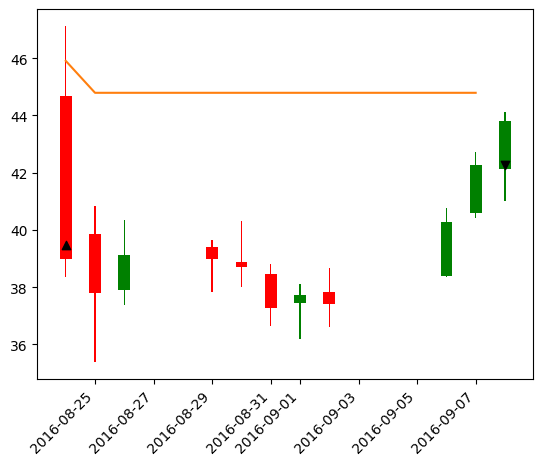

trade 8
entry: [42.5099983215332]
cost_basis: 42.5099983215332
exit: 32.06999969482422
returns: 0.2455892505039376
21


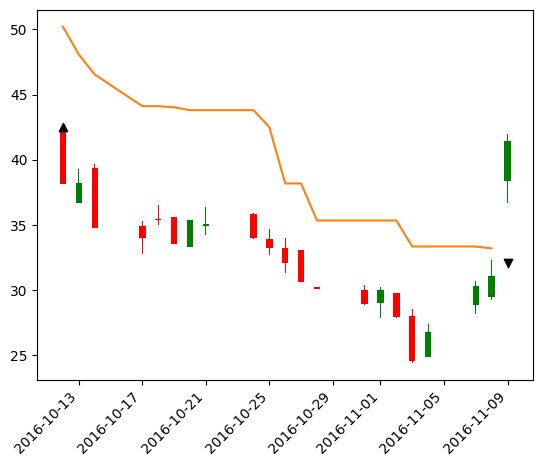

trade 9
entry: [35.130001068115234]
cost_basis: 35.130001068115234
exit: 36.13999938964844
returns: -0.028750307168362143
13


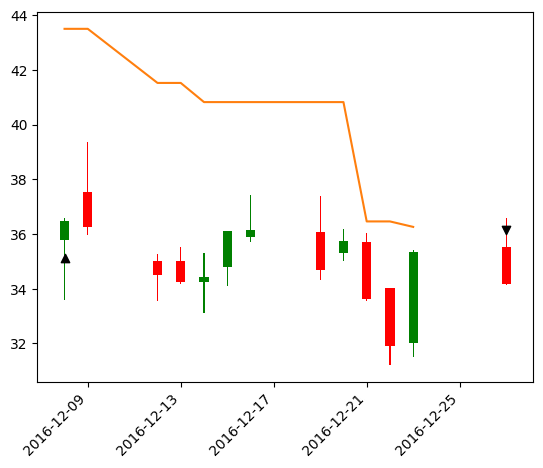

trade 10
entry: [31.899999618530277]
cost_basis: 31.89999961853028
exit: 35.7400016784668
returns: -0.1203762415628968
4


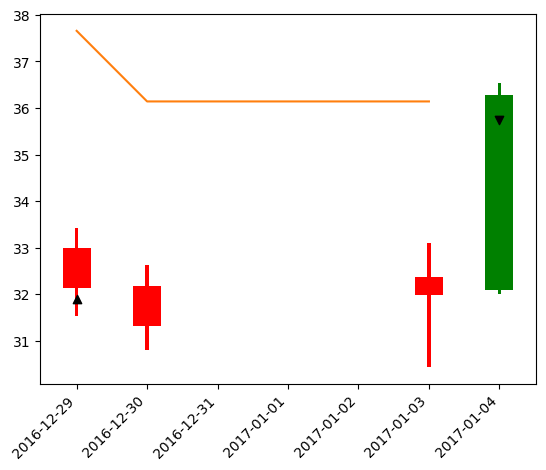

trade 11
entry: [44.27999877929688]
cost_basis: 44.27999877929688
exit: 46.290000915527344
returns: -0.04539300342461252
20


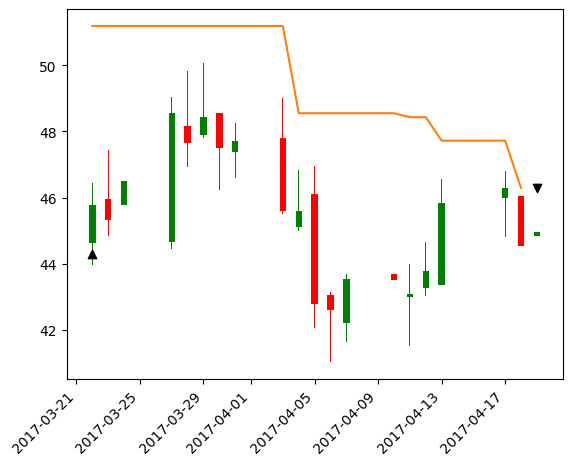

trade 12
entry: [44.84999847412109]
cost_basis: 44.84999847412109
exit: 48.290000915527344
returns: -0.07670016852712212
4


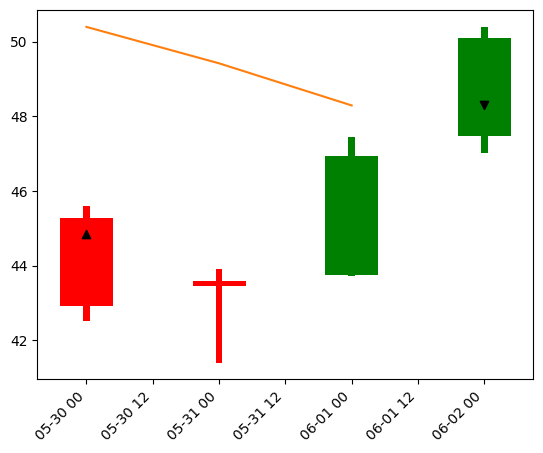

trade 13
entry: [62.630001068115234]
cost_basis: 62.630001068115234
exit: 62.369998931884766
returns: 0.004151399198408048
17


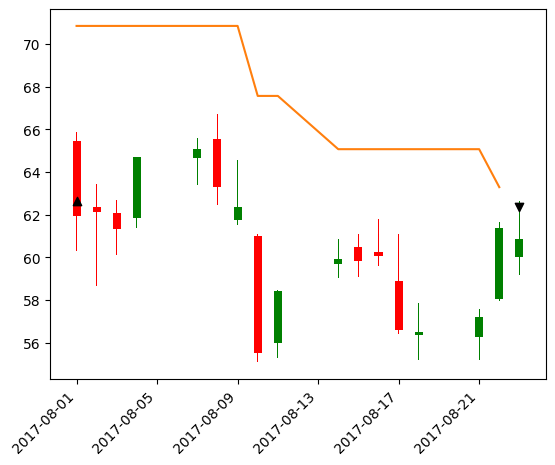

trade 14
entry: [76.23999786376953]
cost_basis: 76.23999786376953
exit: 81.45850219726563
returns: -0.06844837984939157
9


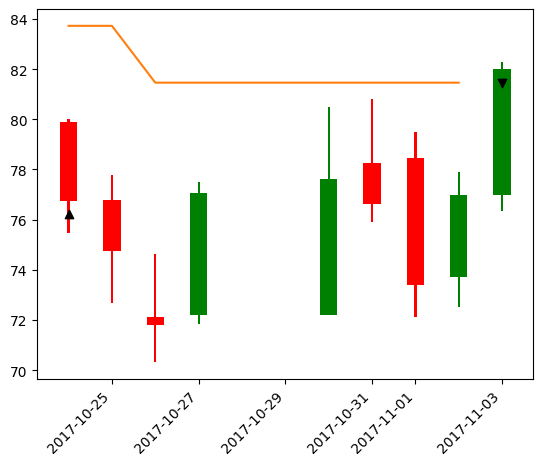

trade 15
entry: [71.80000305175781]
cost_basis: 71.80000305175781
exit: 71.41999816894531
returns: 0.005292546889427976
14


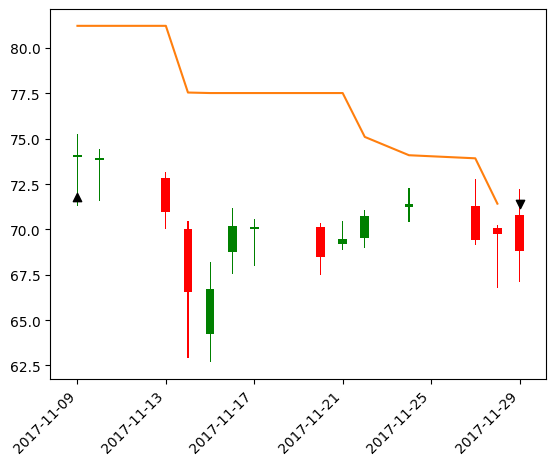

trade 16
entry: [66.55999755859375]
cost_basis: 66.55999755859375
exit: 74.9000015258789
returns: -0.12530054496987214
4


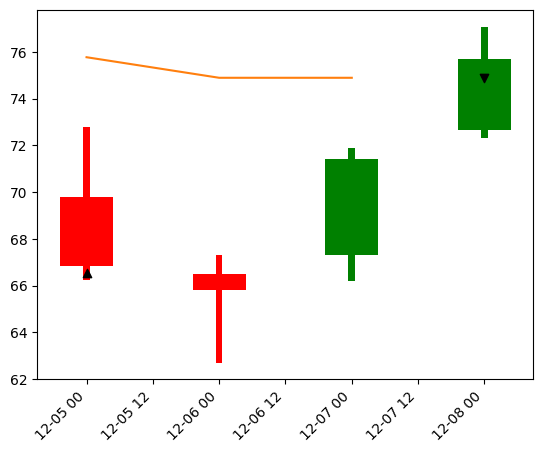

trade 17
entry: [82.41000366210938]
cost_basis: 82.41000366210938
exit: 93.56525192260742
returns: -0.13536279292300313
5


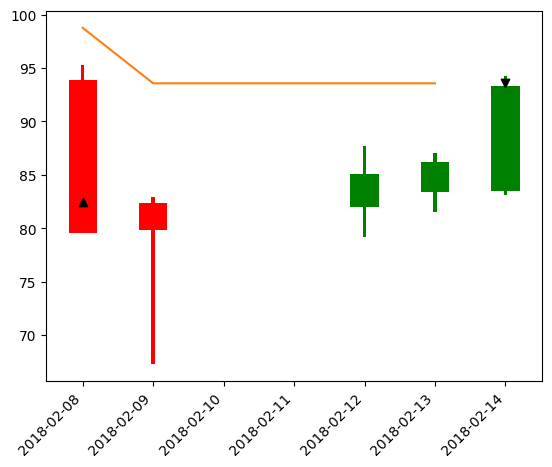

trade 18
entry: [86.2699966430664]
cost_basis: 86.2699966430664
exit: 79.77999877929688
returns: 0.07522891058662326
13


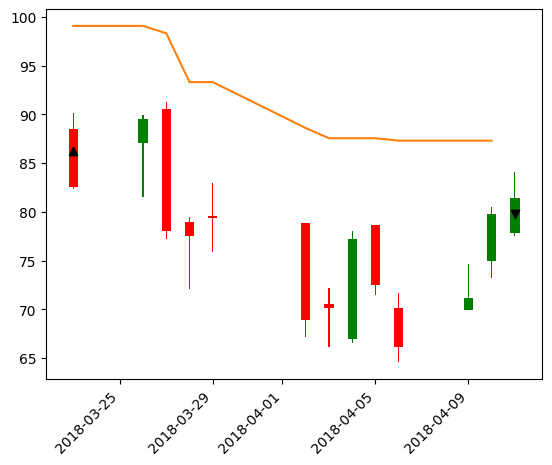

trade 19
entry: [93.4800033569336]
cost_basis: 93.4800033569336
exit: 103.03385086059569
returns: -0.10220204493556503
6


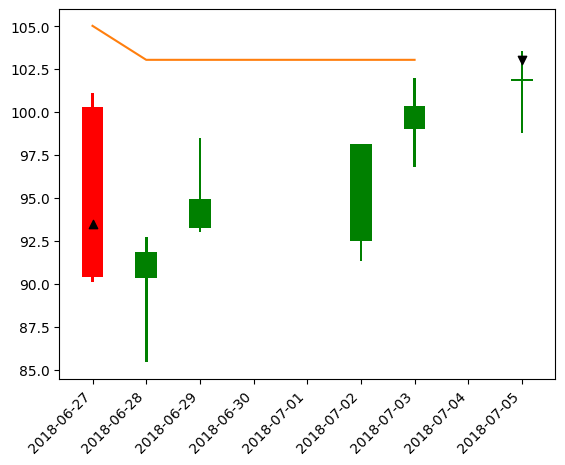

trade 20
entry: [91.83000183105467]
cost_basis: 91.83000183105467
exit: 95.62999725341795
returns: -0.04138076169653538
11


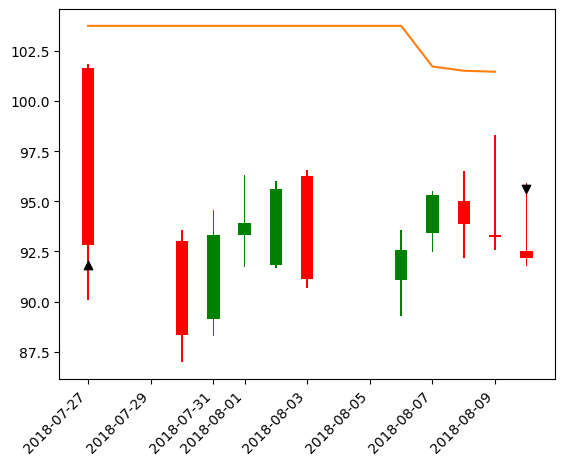

trade 21
entry: [88.3499984741211]
cost_basis: 88.3499984741211
exit: 93.86000061035156
returns: -0.06236561665413523
6


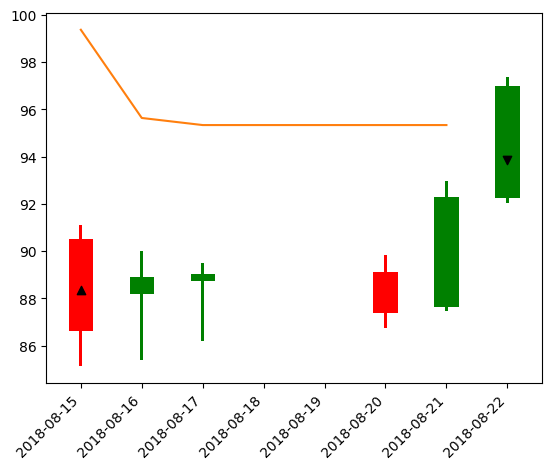

trade 22
entry: [88.9000015258789]
cost_basis: 88.9000015258789
exit: 58.150001525878906
returns: 0.34589425728017154
28


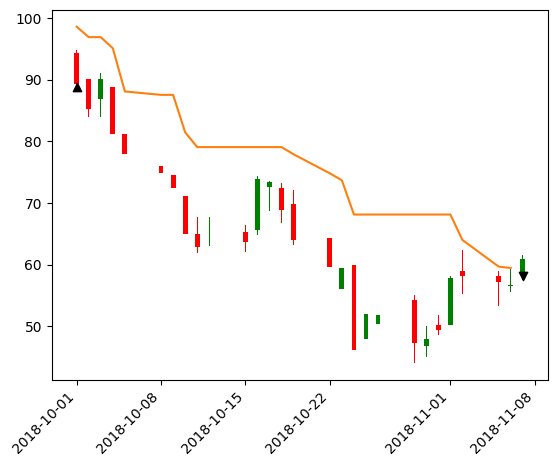

trade 23
entry: [46.15999984741211]
cost_basis: 46.15999984741211
exit: 48.68999862670898
returns: -0.054809332488303907
12


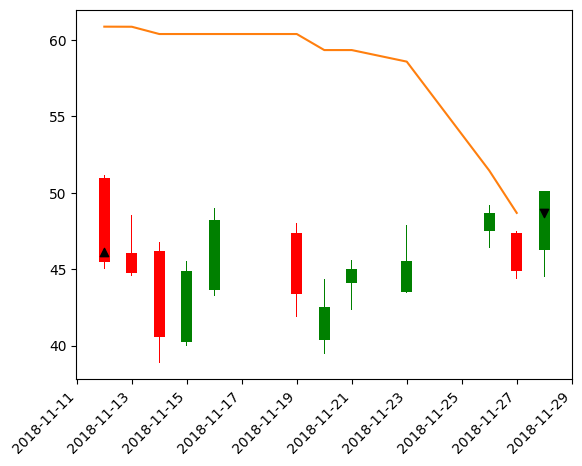

trade 24
entry: [41.630001068115234]
cost_basis: 41.630001068115234
exit: 34.18000030517578
returns: 0.1789574963197748
13


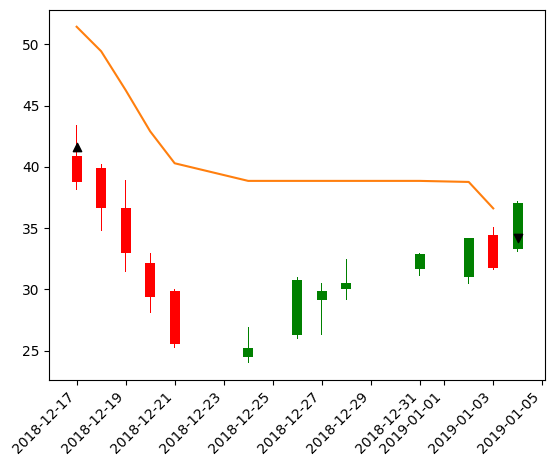

trade 25
entry: [53.20000076293945]
cost_basis: 53.20000076293945
exit: 62.16010093688965
returns: -0.16842293318521984
7


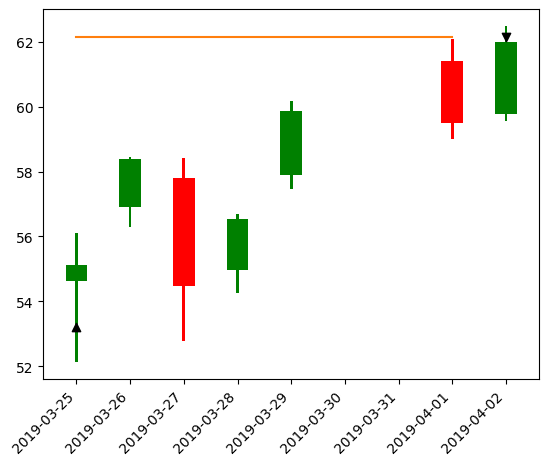

trade 26
entry: [54.47999954223633]
cost_basis: 54.47999954223633
exit: 52.25
returns: 0.04093244421757919
15


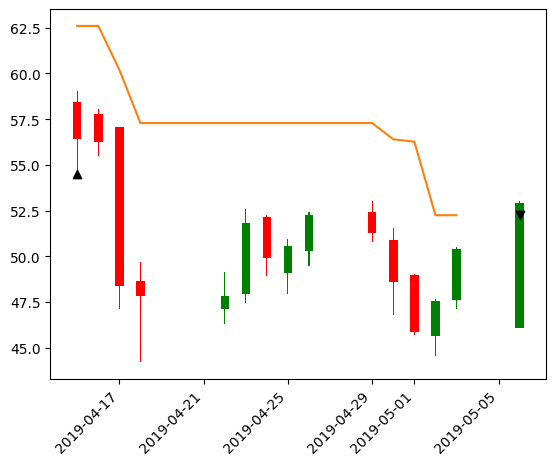

trade 27
entry: [45.86000061035156]
cost_basis: 45.86000061035156
exit: 43.61000061035156
returns: 0.04906236306268447
23


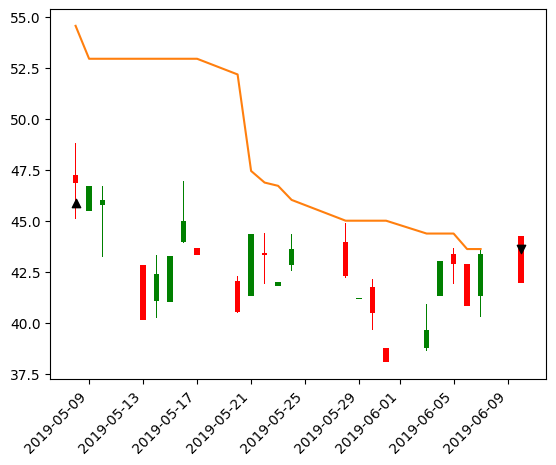

trade 28
entry: [43.900001525878906]
cost_basis: 43.900001525878906
exit: 48.150001525878906
returns: -0.09681093057581419
5


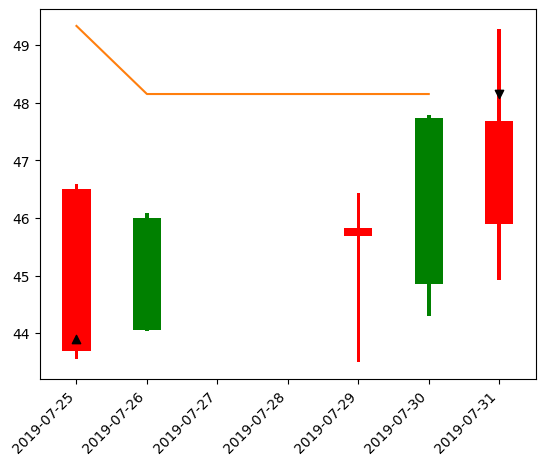

trade 29
entry: [43.68999862670898]
cost_basis: 43.68999862670898
exit: 37.93000030517578
returns: 0.13183791491382515
27


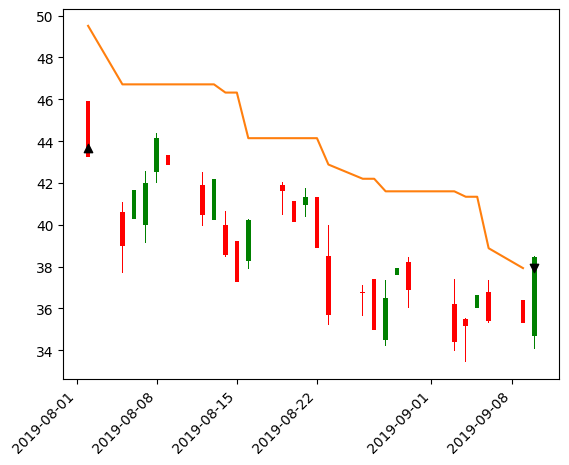

trade 30
entry: [34.400001525878906]
cost_basis: 34.400001525878906
exit: 31.450000762939453
returns: 0.08575583232809411
13


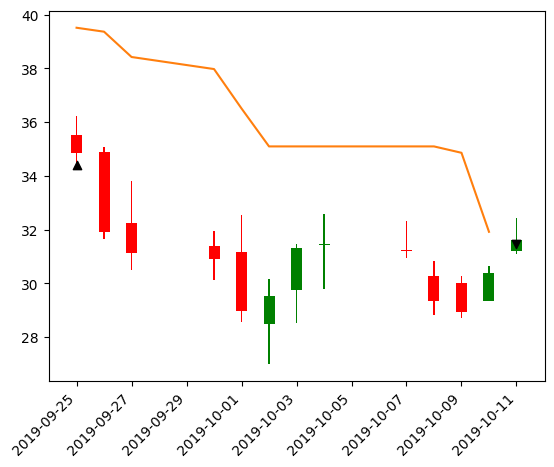

trade 31
entry: [54.45000076293945]
cost_basis: 54.45000076293945
exit: 58.5
returns: -0.07438015023531673
9


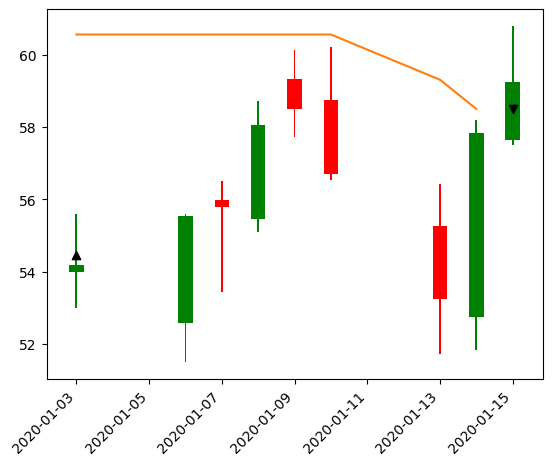

trade 32
entry: [53.25]
cost_basis: 53.25
exit: 55.40965251922607
returns: -0.04055685482114688
10


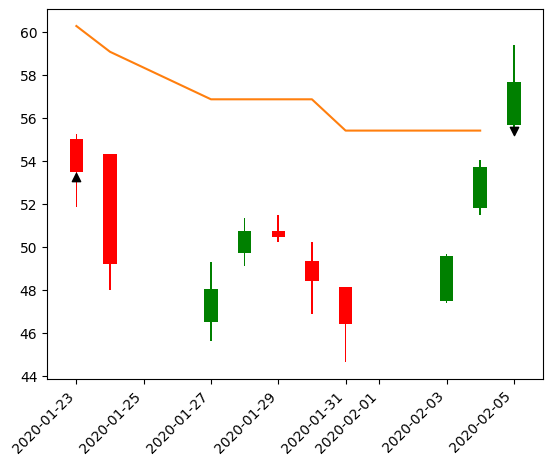

trade 33
entry: [46.41999816894531]
cost_basis: 46.41999816894531
exit: 51.07229995727539
returns: -0.10022192959590505
4


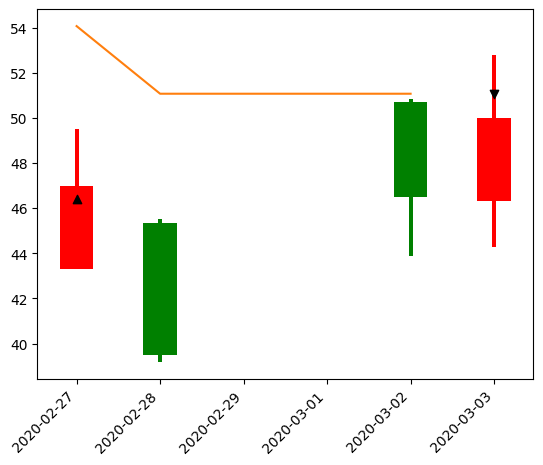

trade 34
entry: [43.29999923706055]
cost_basis: 43.29999923706055
exit: 23.350000381469727
returns: 0.4607390117114732
18


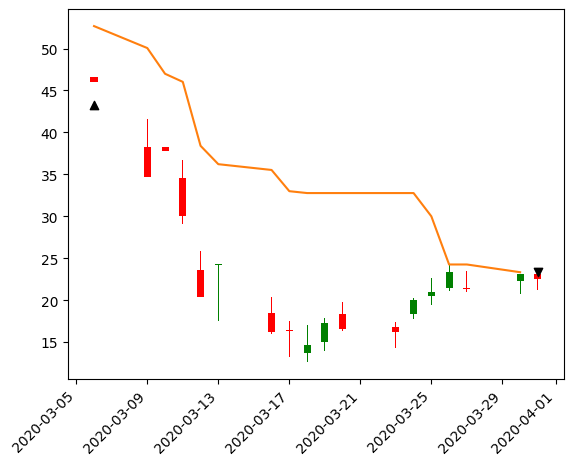

trade 35
entry: [43.34999847412109]
cost_basis: 43.34999847412109
exit: 50.02000045776367
returns: -0.15386394967520975
5


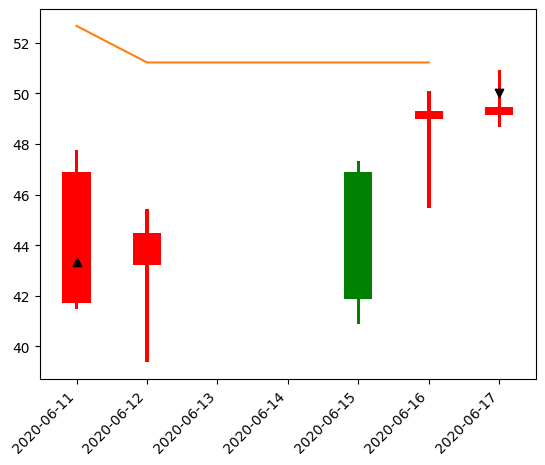

trade 36
entry: [56.66999816894531]
cost_basis: 56.66999816894531
exit: 53.15840167999268
returns: 0.061965706765753165
36


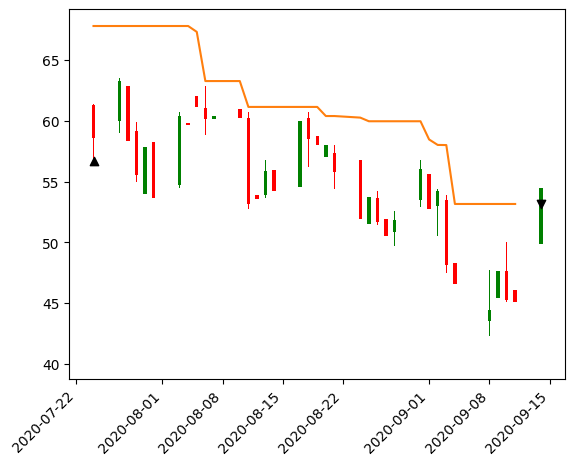

trade 37
entry: [53.77000045776367]
cost_basis: 53.77000045776367
exit: 61.45000076293945
returns: -0.14283057912949843
3


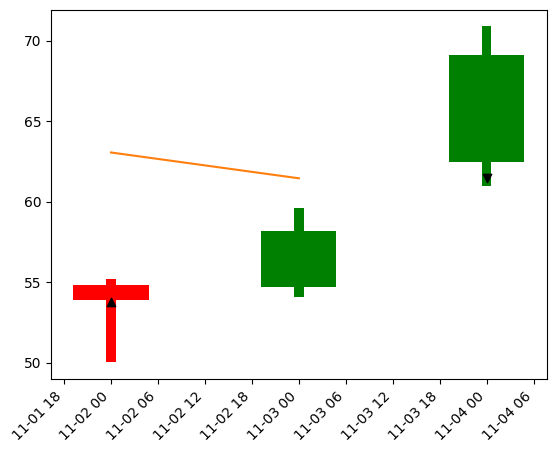

trade 38
entry: [123.16999816894533]
cost_basis: 123.16999816894533
exit: 107.43000030517578
returns: 0.12779084271950608
16


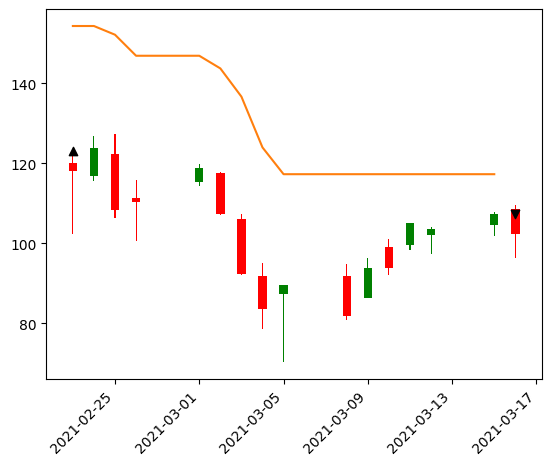

trade 39
entry: [81.88999938964844]
cost_basis: 81.88999938964844
exit: 74.5
returns: 0.09024300213369636
21


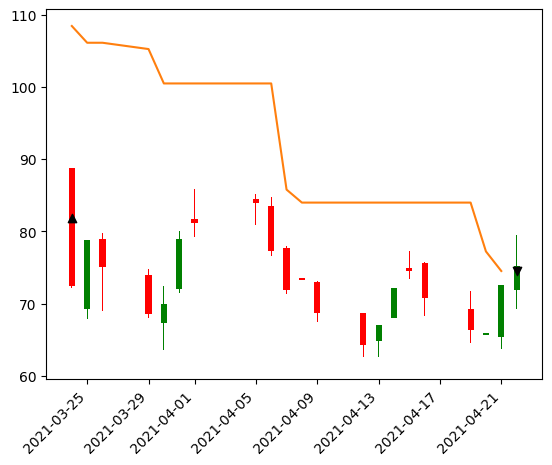

trade 40
entry: [64.20999908447266]
cost_basis: 64.20999908447266
exit: 63.720001220703125
returns: 0.007631176931258097
12


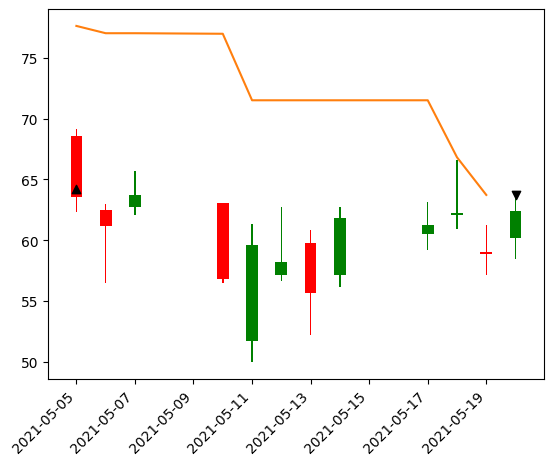

trade 41
entry: [70.47000122070312]
cost_basis: 70.47000122070312
exit: 61.209999084472656
returns: 0.13140346212325602
22


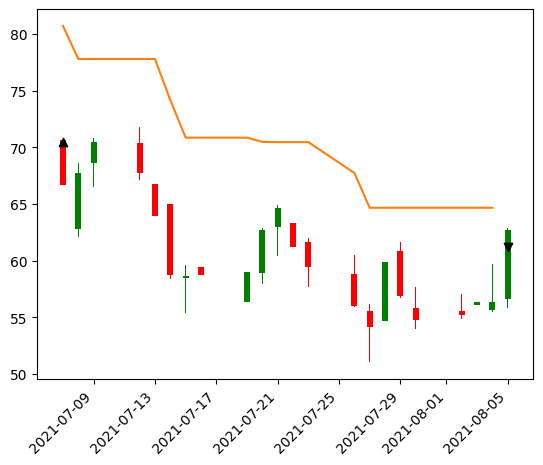

trade 42
entry: [54.18999862670898]
cost_basis: 54.18999862670898
exit: 59.09000015258789
returns: -0.09042261764265515
7


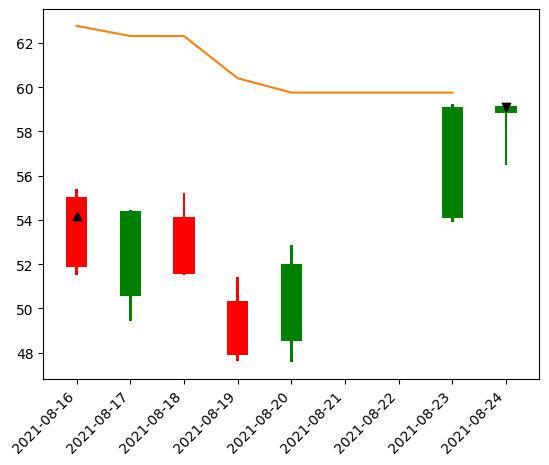

trade 43
entry: [59.77999877929688]
cost_basis: 59.77999877929689
exit: 55.650001525878906
returns: 0.06908660651977616
13


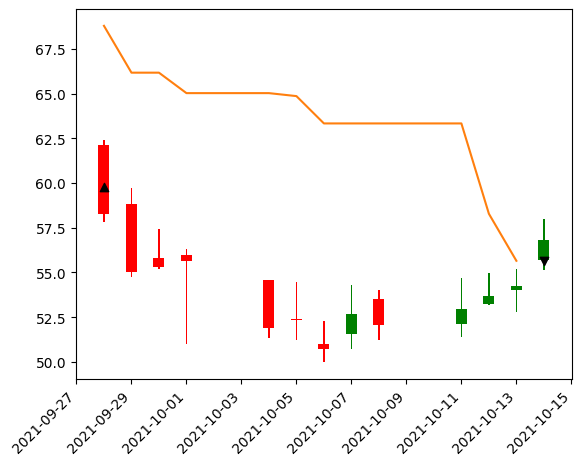

trade 44
entry: [50.70000076293945]
cost_basis: 50.70000076293945
exit: 55.0
returns: -0.0848126069497764
10


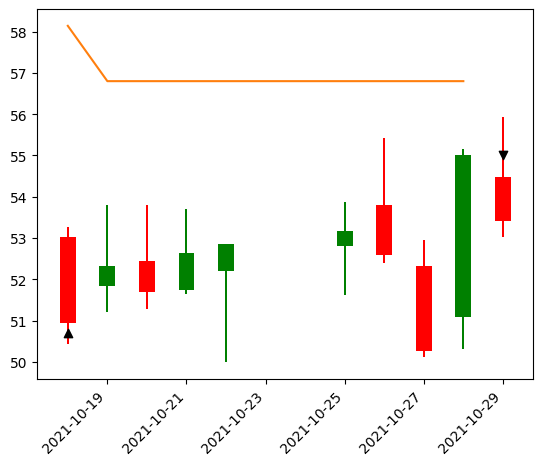

trade 45
entry: [50.27000045776367]
cost_basis: 50.27000045776367
exit: 40.7599983215332
returns: 0.1891784772156641
27


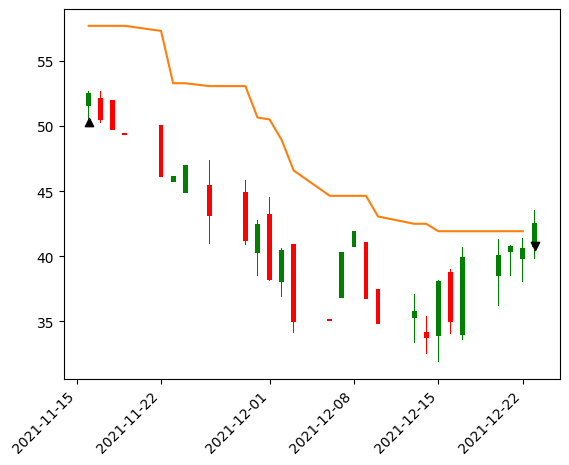

trade 46
entry: [33.7400016784668]
cost_basis: 33.7400016784668
exit: 20.76000022888184
returns: 0.3847066035526881
19


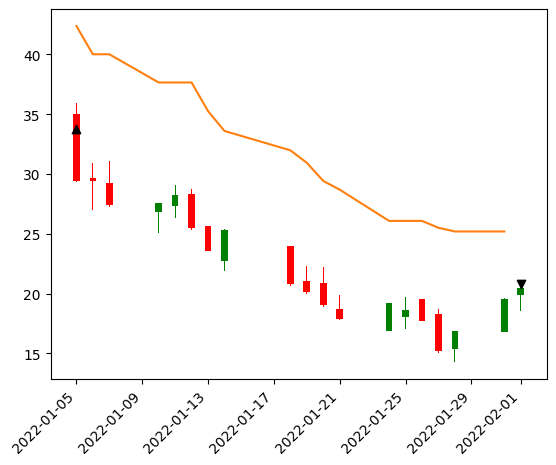

trade 47
entry: [15.18000030517578]
cost_basis: 15.18000030517578
exit: 15.619999885559082
returns: -0.028985479020924666
17


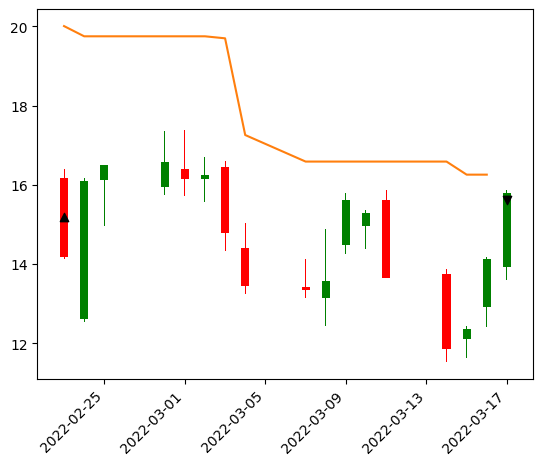

trade 48
entry: [13.979999542236328]
cost_basis: 13.979999542236328
exit: 6.420000076293945
returns: 0.5407725116944487
34


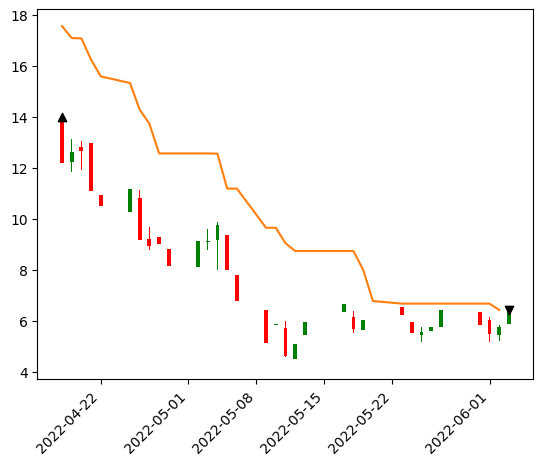

trade 49
entry: [5.230000019073486]
cost_basis: 5.230000019073486
exit: 6.449350070953369
returns: -0.23314532455697684
7


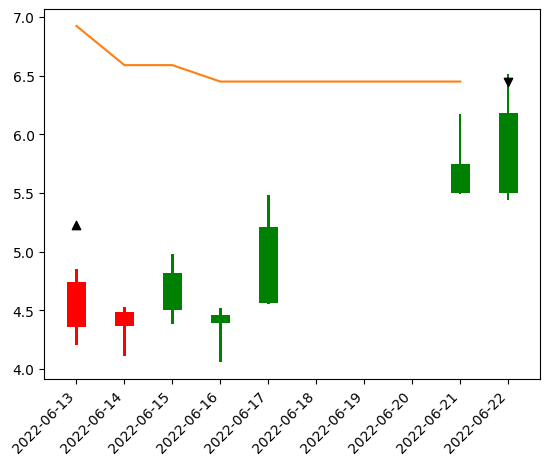

trade 50
entry: [7.869999885559082]
cost_basis: 7.869999885559082
exit: 9.5600004196167
returns: -0.21473958813629132
2


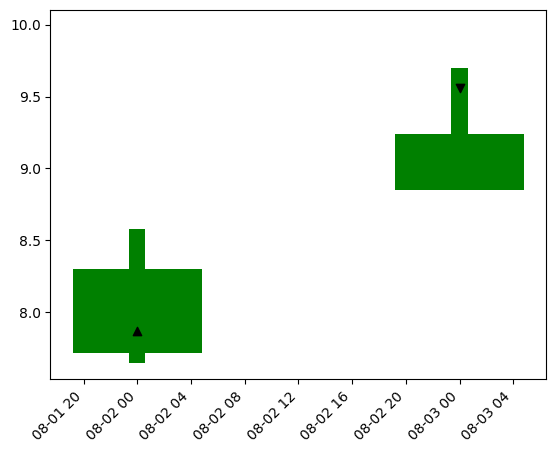

trade 51
entry: [8.300000190734863]
cost_basis: 8.300000190734863
exit: 9.93000030517578
returns: -0.1963855514437765
9


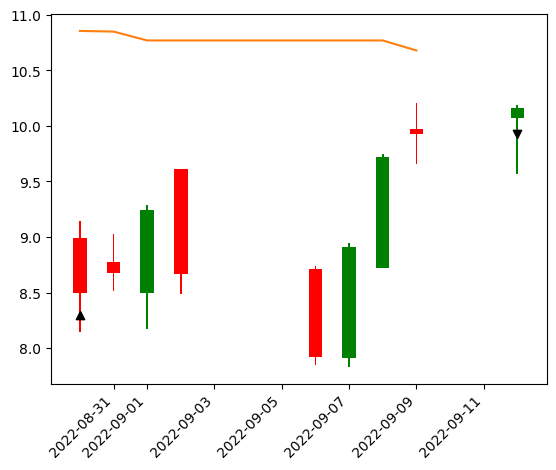

trade 52
entry: [7.920000076293945]
cost_basis: 7.920000076293945
exit: 7.900000095367432
returns: 0.0025252500926581287
12


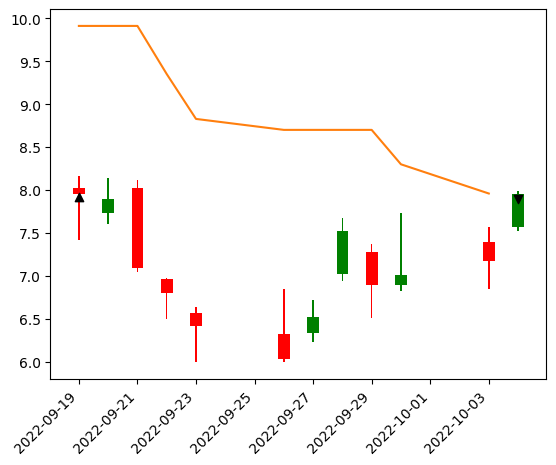

trade 53
entry: [6.03000020980835]
cost_basis: 6.03000020980835
exit: 7.300000190734863
returns: -0.21061358818209358
4


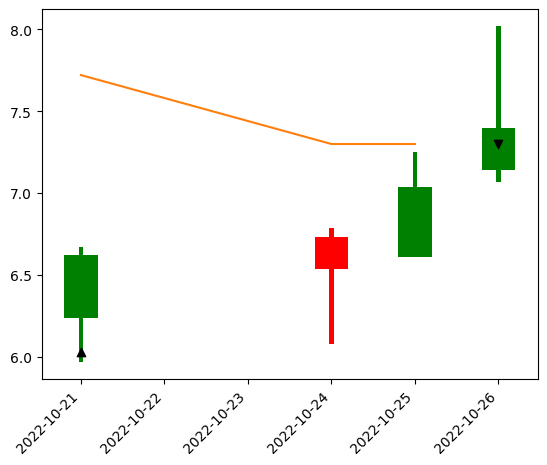

trade 54
entry: [6.130000114440918]
cost_basis: 6.130000114440918
exit: 7.729700231552124
returns: -0.26096249384117765
3


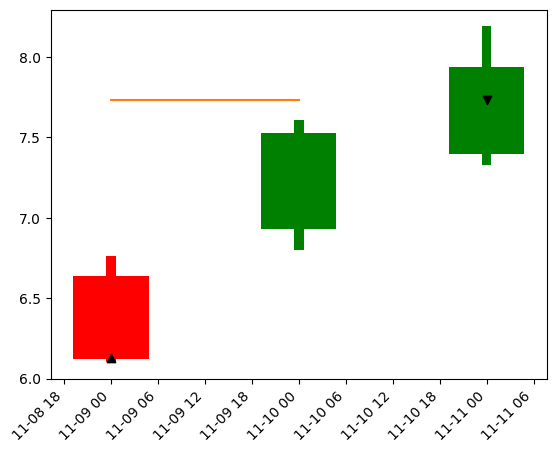

trade 55
entry: [6.519999980926514]
cost_basis: 6.519999980926514
exit: 7.090000152587891
returns: -0.08742333946761424
16


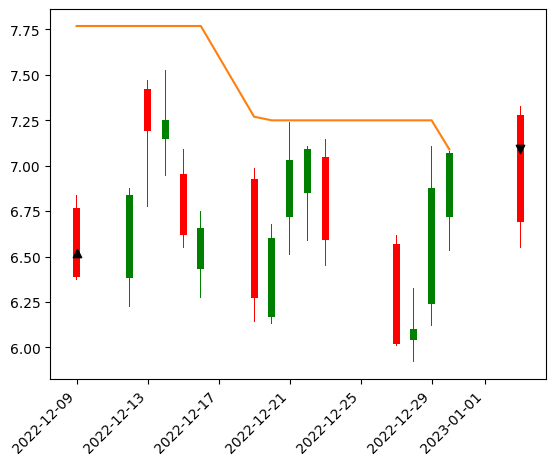

trade 56
entry: [7.449999809265137]
cost_basis: 7.449999809265137
exit: 5.119999885559082
returns: 0.31275167561861783
36


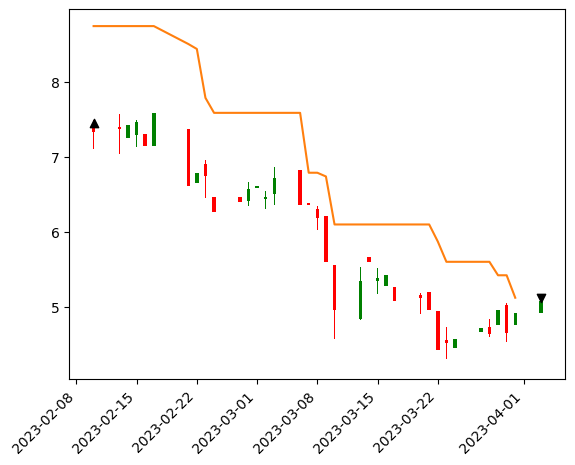

trade 57
entry: [6.050000190734863]
cost_basis: 6.050000190734863
exit: 7.039999961853027
returns: -0.16363632064578723
4


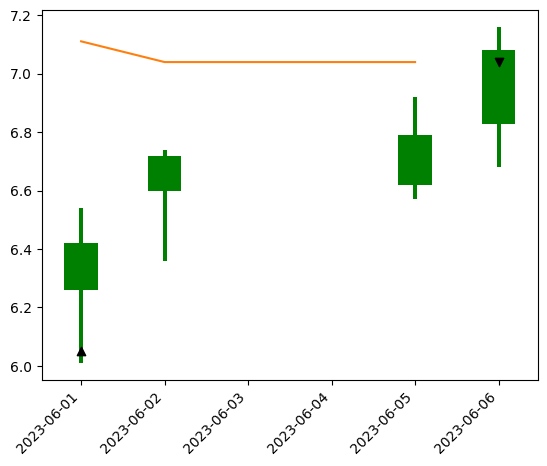

In [150]:
def plot_candle(df, show=False):
    #define width of candlestick elements
    width = .4
    width2 = .05

    #define up and down t.df
    up = df[df.close>=df.open].copy()
    down = df[df.close<df.open].copy()

    #define colors to use
    col1 = 'green'
    col2 = 'red'

    #plot up t.df
    plt.bar(up.index,up.close-up.open,width,bottom=up.open,color=col1)
    plt.bar(up.index,up.high-up.close,width2,bottom=up.close,color=col1)
    plt.bar(up.index,up.low-up.open,width2,bottom=up.open,color=col1)

    #plot down t.df
    plt.bar(down.index,down.close-down.open,width,bottom=down.open,color=col2)
    plt.bar(down.index,down.high-down.open,width2,bottom=down.open,color=col2)
    plt.bar(down.index,down.low-down.close,width2,bottom=down.close,color=col2)

    #rotate x-axis tick labels
    plt.xticks(rotation=45, ha='right')

    if show:
        #display candlestick chart
        plt.show()


for i in range(len(tl.list)):
    t = tl.list[i]

    print(f'trade {i}')
    print(f'entry: {t.entry_price}')
    print(f'cost_basis: {t.cost_basis}')
    print(f'exit: {t.exit_price}')
    print(f'returns: {t.returns}')
    
    
    plot_candle(t.df)
    print(len(t.df))
    
    
    plt.plot(t.df['stop_loss'], color='C1')
    plt.scatter(t.df.index, t.df['entry_price'], marker='^', color='black')
    plt.scatter(t.df.index, t.df['exit_price'], marker='v', color='black')
    plt.show()



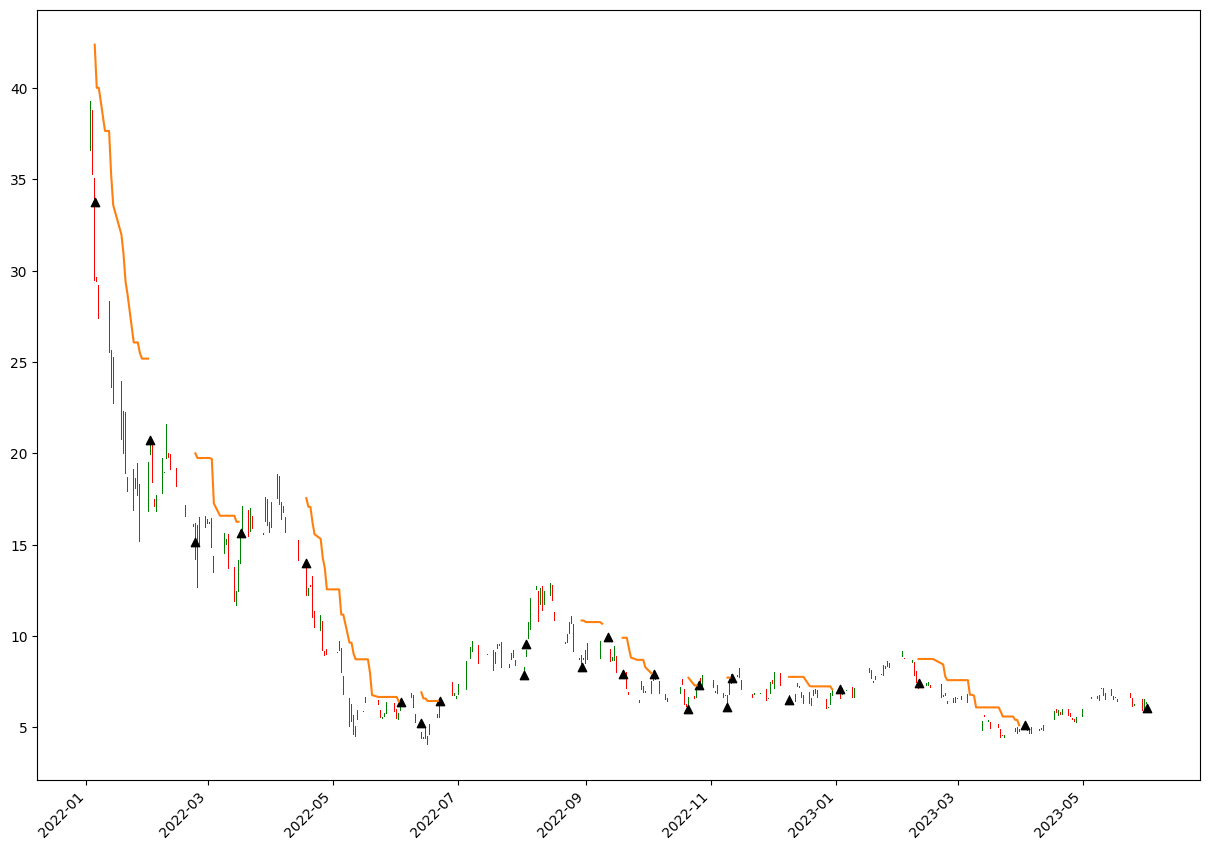

In [151]:
import datetime as dt
mask = (df.index >= pd.to_datetime(dt.date(2022, 1, 1))) & (df.index <= pd.to_datetime(dt.date(2023, 6, 1)))
df1 = df.loc[mask]
    
plt.figure(figsize=(15,10)) 
plot_candle(df1)

plt.plot(df1['stop_loss'], color='C1')
plt.scatter(df1.index, df1['entry_price'], marker='^', color='black')
plt.scatter(df1.index, df1['exit_price'], marker='^', color='black')
plt.show()

<Axes: >

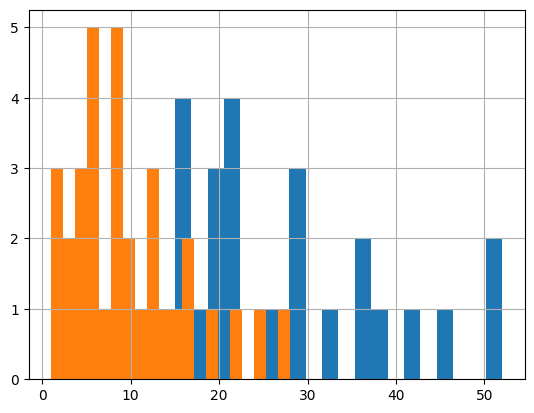

In [152]:
tl.win_records['time_in_trade'].hist(bins=20)
tl.loss_records['time_in_trade'].hist(bins=20)

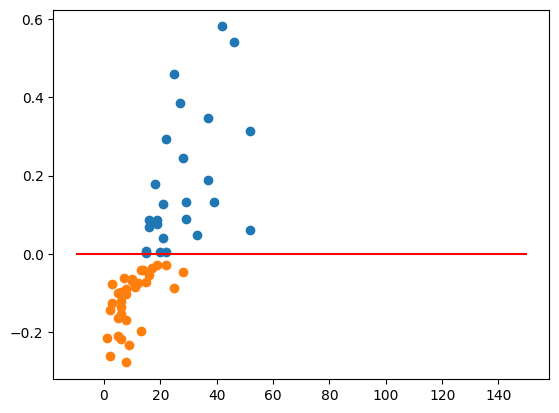

In [153]:
plt.scatter(tl.win_records['time_in_trade'], tl.win_records['returns'])
plt.scatter(tl.loss_records['time_in_trade'], tl.loss_records['returns'])
plt.hlines(0, -10, 150, color='red')